# OLED Optimization with FourierFields


In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Al as ALU

mp.verbosity(0)

GLS = mp.Medium(index=1.5)    # 글래스의 굴절률 설정
ITO = mp.Medium(index=1.2)    # ITO의 굴절률 설정
ORG = mp.Medium(index=1.75)   # OLED 유기층의 굴절률 설정
SiN = mp.Medium(index=1.9)    # 실리콘 질화물의 굴절률 설정

Basic setup

In [2]:
lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.8       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 25             # 추출할 주파수 개수
design_region_resolution = 50      


wavelengths = np.array([0.5, 0.6, 0.7])
frequencies = 1/wavelengths


tABS = 0.5    # X/Y 방향 흡수 경계층 두께
tPML = 0.5    # Z 방향 PML 경계층 두께
tGLS = 0.5    # 글래스 층 두께
tITO = 0.5    # ITO 층 두께
tORG = 0.5    # 유기층(OLED 발광층) 두께
tALU = 0.2    # 알루미늄(캐소드) 두께

L = 1.0       # OLED의 가로/세로 길이

design_region_width = L
design_region_height = 0.2

Sy = tPML + tGLS + design_region_height + tITO + tORG + tALU  # Z 방향 전체 길이
Sx = L + 2*tABS                        # X/Y 방향 길이
cell_size = mp.Vector3(Sx, Sy)    # 시뮬레이션 셀 크기

boundary_layers = [mp.Absorber(tABS,direction=mp.X),
                   mp.PML(tPML,direction=mp.Y,side=mp.High)]

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), GLS, SiN, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(y=0.5*Sy - tPML - tGLS - 0.5*design_region_height),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

geometry = [
    mp.Block(material=GLS,      # 유리층
             size=mp.Vector3(mp.inf, tPML + tGLS),
             center=mp.Vector3(y=0.5*Sy - 0.5*(tPML + tGLS))),

    mp.Block(material=design_variables,      # 디자인 영역
             size=design_region.size,
             center=design_region.center),
    
    mp.Block(material=ITO,      # ITO 층
             size=mp.Vector3(mp.inf, tITO),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - 0.5*tITO)),
    
    mp.Block(material=ORG,                       # 유기층
             size=mp.Vector3(mp.inf, tORG),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG)),
    
    mp.Block(material=ALU,                       # 알루미늄 층
             size=mp.Vector3(mp.inf, tALU),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - tORG - 0.5*tALU))
]

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = []
src_num = 5

for i in range(src_num):  # x 방향 루프
        sources.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG,
                    z = 0
                )
            )
        )

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,
                    extra_materials=[ALU],)
                    

<Axes: xlabel='X', ylabel='Y'>

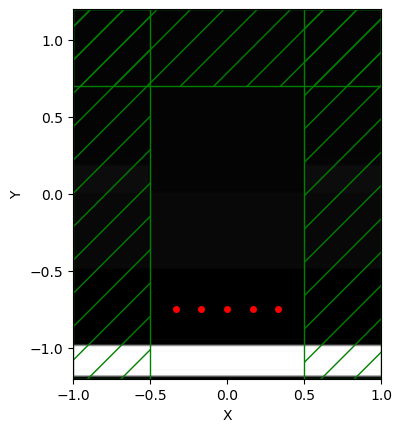

In [3]:
sim.plot2D()

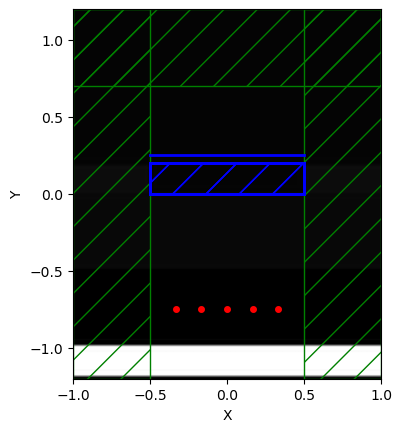

In [4]:
monitor_position, monitor_size = mp.Vector3(0,0.5*Sy-tPML-(tGLS-0.05)), mp.Vector3(L,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.abs(fields[:,:]) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    maximum_run_time=100,
)
opt.plot2D(True)

In [5]:
minimum_length = 0.02  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

In [6]:
def mapping(x, eta, beta):

    # # filter
    # filtered_field = mpa.conic_filter(
    #     x,
    #     filter_radius,
    #     design_region_width,
    #     design_region_height,
    #     design_region_resolution,
    # )

    # # projection
    # projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return x

In [7]:
evaluation_history = []
cur_iter = [0]

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])  # compute objective and gradient

    print("FoM: {}".format(np.real(f0)))
    print("Gradient: {}".format(np.real(dJ_du)))

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, np.sum(dJ_du, axis=1)
        )  # backprop

    evaluation_history.append(np.real(f0))

    print("First FoM: {}".format(evaluation_history[0]))
    print("Current FoM: {}".format(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

In [8]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

cur_beta = 4
beta_scale = 1.5
num_betas = 9
update_factor = 12
ftol = 1e-5
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    solver.set_ftol_rel(ftol)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

Current iteration: 1
Starting forward run...


Starting adjoint run...


Calculating gradient...
FoM: 0.37796776771286045
Gradient: [[ 8.40235919e-05  3.17233555e-05  1.85122133e-07]
 [ 2.13378825e-04  8.18722523e-05  1.92437195e-07]
 [ 2.41661294e-04  1.01155239e-04 -4.14930330e-07]
 ...
 [-2.47339692e-04 -6.44303158e-05 -5.17429286e-07]
 [-7.02612981e-05 -3.19052672e-05  1.14835850e-07]
 [ 1.47235617e-04  2.74770570e-05  1.11369298e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.37796776771286045
Current iteration: 2
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.378050561185119
Gradient: [[ 8.40814858e-05  3.17273177e-05  1.85098067e-07]
 [ 2.13500387e-04  8.18864829e-05  1.92346408e-07]
 [ 2.41740397e-04  1.01181632e-04 -4.15113114e-07]
 ...
 [-2.47508601e-04 -6.44375749e-05 -5.17363932e-07]
 [-7.03230942e-05 -3.19114109e-05  1.14978014e-07]
 [ 1.47286766e-04  2.74772817e-05  1.11398968e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.378050561185119
Current iteration: 3
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.37887037972851384
Gradient: [[ 8.46541989e-05  3.17666904e-05  1.84851930e-07]
 [ 2.14701412e-04  8.20275636e-05  1.91427651e-07]
 [ 2.42516913e-04  1.01442751e-04 -4.16947903e-07]
 ...
 [-2.49178904e-04 -6.45085245e-05 -5.16714213e-07]
 [-7.09324433e-05 -3.19713285e-05  1.16390310e-07]
 [ 1.47794384e-04  2.74802506e-05  1.11691612e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.37887037972851384
Current iteration: 4
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.3894777018874079
Gradient: [[ 9.20357044e-05  3.22898139e-05  1.81256305e-07]
 [ 2.29980154e-04  8.38809691e-05  1.78584095e-07]
 [ 2.51785885e-04  1.04841516e-04 -4.41655913e-07]
 ...
 [-2.70464996e-04 -6.52903834e-05 -5.07632521e-07]
 [-7.85275413e-05 -3.26348906e-05  1.34805614e-07]
 [ 1.54492786e-04  2.76002416e-05  1.15377551e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.3894777018874079
Current iteration: 5
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.4693576162047377
Gradient: [[ 1.40212926e-04  3.71461351e-05  1.22524752e-07]
 [ 3.13667479e-04  9.97008733e-05  9.63546298e-09]
 [ 2.52976167e-04  1.31716179e-04 -6.97930899e-07]
 ...
 [-4.07352338e-04 -6.48611058e-05 -3.93635629e-07]
 [-1.16904125e-04 -3.20985993e-05  2.94494073e-07]
 [ 2.09197371e-04  3.32889525e-05  1.40473175e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.4693576162047377
Current iteration: 6
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.5690779184462744
Gradient: [[ 1.05637196e-04  4.67521647e-05 -8.86920846e-08]
 [ 1.42973123e-04  1.25254618e-04 -5.11997732e-07]
 [-1.60332786e-04  1.65810820e-04 -1.30587240e-06]
 ...
 [-5.49061415e-04 -3.51047667e-05 -7.72901204e-08]
 [-1.87599494e-04 -8.59670508e-06  5.58294210e-07]
 [ 1.70181091e-04  5.32457378e-05  1.58546029e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.5690779184462744
Current iteration: 7
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.5748766169983388
Gradient: [[ 1.66908468e-04  4.26330518e-05  5.24742342e-08]
 [ 3.01608611e-04  1.15485131e-04 -1.77908650e-07]
 [ 5.07968902e-05  1.54870403e-04 -9.32913456e-07]
 ...
 [-7.07997461e-04 -2.49539582e-05 -1.40061668e-07]
 [-3.71196845e-04 -1.53453439e-06  4.67251690e-07]
 [-8.31113418e-05  5.82713113e-05  1.43596525e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.5748766169983388
Current iteration: 8
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.5740822321494052
Gradient: [[ 2.28538062e-05  5.51781913e-05  1.37254860e-07]
 [-8.57593571e-05  1.47176873e-04  2.37320229e-08]
 [-4.79559321e-04  1.93925445e-04 -7.09159540e-07]
 ...
 [-7.27967925e-04 -2.26790201e-05 -1.47500316e-07]
 [-3.09458058e-04 -4.86858055e-06  3.82790084e-07]
 [ 6.77642418e-05  4.49689585e-05  1.18461353e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.5740822321494052
Current iteration: 9
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.5752560872374711
Gradient: [[ 8.56425125e-05  4.97630081e-05  1.11189712e-07]
 [ 8.22687137e-05  1.33635989e-04 -3.85570801e-08]
 [-2.51176837e-04  1.77509256e-04 -7.78848755e-07]
 ...
 [-7.25548237e-04 -2.36852917e-05 -1.47512666e-07]
 [-3.38998836e-04 -3.68669316e-06  4.11463631e-07]
 [ 4.72473054e-06  5.03130206e-05  1.27730050e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.5752560872374711
Current iteration: 10
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.5755044218134515
Gradient: [[ 1.28506783e-04  4.53165914e-05  9.12758497e-08]
 [ 1.96922109e-04  1.22418012e-04 -8.53714467e-08]
 [-9.55754095e-05  1.63902824e-04 -8.30111263e-07]
 ...
 [-7.30406531e-04 -2.40771700e-05 -1.53549323e-07]
 [-3.66484436e-04 -2.56481184e-06  4.26797763e-07]
 [-5.05960487e-05  5.41401525e-05  1.33769938e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.5755044218134515
Current iteration: 11
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.5754177167122756
Gradient: [[ 8.15402523e-05  5.02587846e-05  1.30146736e-07]
 [ 7.07885652e-05  1.34704346e-04  6.55981355e-09]
 [-2.67319207e-04  1.78389362e-04 -7.28336941e-07]
 ...
 [-7.35090910e-04 -2.25483257e-05 -1.36893407e-07]
 [-3.45802816e-04 -2.50313802e-06  4.16682964e-07]
 [ 4.98702847e-07  5.20981161e-05  1.27821332e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.5754177167122756
Current iteration: 12
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.5755239015514592
Gradient: [[ 1.12194998e-04  4.72357015e-05  9.73435153e-08]
 [ 1.52994100e-04  1.27219966e-04 -7.13049374e-08]
 [-1.55726036e-04  1.69521772e-04 -8.14559949e-07]
 ...
 [-7.26337198e-04 -2.36095070e-05 -1.40065791e-07]
 [-3.54138772e-04 -2.45593500e-06  4.33290323e-07]
 [-2.67729034e-05  5.37123120e-05  1.33365514e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.5755239015514592
Current iteration: 13
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.5755239015514592
Gradient: [[ 1.12194998e-04  4.72357015e-05  9.73435153e-08]
 [ 1.52994100e-04  1.27219966e-04 -7.13049374e-08]
 [-1.55726036e-04  1.69521772e-04 -8.14559949e-07]
 ...
 [-7.26337198e-04 -2.36095070e-05 -1.40065791e-07]
 [-3.54138772e-04 -2.45593500e-06  4.33290323e-07]
 [-2.67729034e-05  5.37123120e-05  1.33365514e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.5755239015514592
Current iteration: 14
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.575523914051622
Gradient: [[ 1.12196086e-04  4.72355816e-05  9.73430361e-08]
 [ 1.52996971e-04  1.27219660e-04 -7.13060627e-08]
 [-1.55722216e-04  1.69521386e-04 -8.14561144e-07]
 ...
 [-7.26337608e-04 -2.36094811e-05 -1.40065356e-07]
 [-3.54139694e-04 -2.45585689e-06  4.33291406e-07]
 [-2.67744790e-05  5.37124905e-05  1.33365785e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.575523914051622
Current iteration: 15
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.575523914051622
Gradient: [[ 1.12196086e-04  4.72355816e-05  9.73430361e-08]
 [ 1.52996971e-04  1.27219660e-04 -7.13060627e-08]
 [-1.55722216e-04  1.69521386e-04 -8.14561144e-07]
 ...
 [-7.26337608e-04 -2.36094811e-05 -1.40065356e-07]
 [-3.54139694e-04 -2.45585689e-06  4.33291406e-07]
 [-2.67744790e-05  5.37124905e-05  1.33365785e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.575523914051622
Current iteration: 16
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.5755239265500749
Gradient: [[ 1.12197174e-04  4.72354617e-05  9.73425571e-08]
 [ 1.52999841e-04  1.27219354e-04 -7.13071876e-08]
 [-1.55718396e-04  1.69521000e-04 -8.14562338e-07]
 ...
 [-7.26338019e-04 -2.36094552e-05 -1.40064922e-07]
 [-3.54140616e-04 -2.45577879e-06  4.33292489e-07]
 [-2.67760541e-05  5.37126689e-05  1.33366056e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.5755239265500749
Current iteration: 17
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.5755239265500749
Gradient: [[ 1.12197174e-04  4.72354617e-05  9.73425571e-08]
 [ 1.52999841e-04  1.27219354e-04 -7.13071876e-08]
 [-1.55718396e-04  1.69521000e-04 -8.14562338e-07]
 ...
 [-7.26338019e-04 -2.36094552e-05 -1.40064922e-07]
 [-3.54140616e-04 -2.45577879e-06  4.33292489e-07]
 [-2.67760541e-05  5.37126689e-05  1.33366056e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.5755239265500749
Current iteration: 18
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.5755239390468202
Gradient: [[ 1.12198261e-04  4.72353419e-05  9.73420783e-08]
 [ 1.53002710e-04  1.27219048e-04 -7.13083119e-08]
 [-1.55714578e-04  1.69520614e-04 -8.14563531e-07]
 ...
 [-7.26338430e-04 -2.36094293e-05 -1.40064487e-07]
 [-3.54141538e-04 -2.45570071e-06  4.33293572e-07]
 [-2.67776288e-05  5.37128473e-05  1.33366326e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.5755239390468202
Current iteration: 19
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.5755239390468202
Gradient: [[ 1.12198261e-04  4.72353419e-05  9.73420783e-08]
 [ 1.53002710e-04  1.27219048e-04 -7.13083119e-08]
 [-1.55714578e-04  1.69520614e-04 -8.14563531e-07]
 ...
 [-7.26338430e-04 -2.36094293e-05 -1.40064487e-07]
 [-3.54141538e-04 -2.45570071e-06  4.33293572e-07]
 [-2.67776288e-05  5.37128473e-05  1.33366326e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.5755239390468202
Current iteration: 20
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.575523951541857
Gradient: [[ 1.12199349e-04  4.72352220e-05  9.73415997e-08]
 [ 1.53005579e-04  1.27218742e-04 -7.13094357e-08]
 [-1.55710761e-04  1.69520228e-04 -8.14564723e-07]
 ...
 [-7.26338841e-04 -2.36094034e-05 -1.40064052e-07]
 [-3.54142460e-04 -2.45562263e-06  4.33294654e-07]
 [-2.67792031e-05  5.37130257e-05  1.33366596e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.575523951541857
Current iteration: 21
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.575523951541857
Gradient: [[ 1.12199349e-04  4.72352220e-05  9.73415997e-08]
 [ 1.53005579e-04  1.27218742e-04 -7.13094357e-08]
 [-1.55710761e-04  1.69520228e-04 -8.14564723e-07]
 ...
 [-7.26338841e-04 -2.36094034e-05 -1.40064052e-07]
 [-3.54142460e-04 -2.45562263e-06  4.33294654e-07]
 [-2.67792031e-05  5.37130257e-05  1.33366596e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.575523951541857
Current iteration: 22
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.5755239640351866
Gradient: [[ 1.12200436e-04  4.72351023e-05  9.73411213e-08]
 [ 1.53008446e-04  1.27218436e-04 -7.13105590e-08]
 [-1.55706944e-04  1.69519842e-04 -8.14565916e-07]
 ...
 [-7.26339252e-04 -2.36093775e-05 -1.40063618e-07]
 [-3.54143381e-04 -2.45554457e-06  4.33295737e-07]
 [-2.67807770e-05  5.37132040e-05  1.33366867e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.5755239640351866
Current iteration: 23
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.5755239640351866
Gradient: [[ 1.12200436e-04  4.72351023e-05  9.73411213e-08]
 [ 1.53008446e-04  1.27218436e-04 -7.13105590e-08]
 [-1.55706944e-04  1.69519842e-04 -8.14565916e-07]
 ...
 [-7.26339252e-04 -2.36093775e-05 -1.40063618e-07]
 [-3.54143381e-04 -2.45554457e-06  4.33295737e-07]
 [-2.67807770e-05  5.37132040e-05  1.33366867e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.5755239640351866
Current iteration: 24
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.5755239765268103
Gradient: [[ 1.12201523e-04  4.72349825e-05  9.73406432e-08]
 [ 1.53011313e-04  1.27218130e-04 -7.13116818e-08]
 [-1.55703129e-04  1.69519456e-04 -8.14567107e-07]
 ...
 [-7.26339663e-04 -2.36093516e-05 -1.40063183e-07]
 [-3.54144303e-04 -2.45546651e-06  4.33296819e-07]
 [-2.67823504e-05  5.37133823e-05  1.33367137e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.5755239765268103
Current iteration: 25
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.5755239765268103
Gradient: [[ 1.12201523e-04  4.72349825e-05  9.73406432e-08]
 [ 1.53011313e-04  1.27218130e-04 -7.13116818e-08]
 [-1.55703129e-04  1.69519456e-04 -8.14567107e-07]
 ...
 [-7.26339663e-04 -2.36093516e-05 -1.40063183e-07]
 [-3.54144303e-04 -2.45546651e-06  4.33296819e-07]
 [-2.67823504e-05  5.37133823e-05  1.33367137e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.5755239765268103
Current iteration: 26
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.5755239890167282
Gradient: [[ 1.12202609e-04  4.72348628e-05  9.73401652e-08]
 [ 1.53014180e-04  1.27217824e-04 -7.13128040e-08]
 [-1.55699315e-04  1.69519070e-04 -8.14568298e-07]
 ...
 [-7.26340073e-04 -2.36093257e-05 -1.40062749e-07]
 [-3.54145224e-04 -2.45538847e-06  4.33297901e-07]
 [-2.67839234e-05  5.37135606e-05  1.33367407e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.5755239890167282
Current iteration: 27
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.5755239890167282
Gradient: [[ 1.12202609e-04  4.72348628e-05  9.73401652e-08]
 [ 1.53014180e-04  1.27217824e-04 -7.13128040e-08]
 [-1.55699315e-04  1.69519070e-04 -8.14568298e-07]
 ...
 [-7.26340073e-04 -2.36093257e-05 -1.40062749e-07]
 [-3.54145224e-04 -2.45538847e-06  4.33297901e-07]
 [-2.67839234e-05  5.37135606e-05  1.33367407e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.5755239890167282
Current iteration: 28
Starting forward run...
Starting adjoint run...
Calculating gradient...
FoM: 0.5755240015049407
Gradient: [[ 1.12203696e-04  4.72347431e-05  9.73396875e-08]
 [ 1.53017045e-04  1.27217518e-04 -7.13139258e-08]
 [-1.55695502e-04  1.69518685e-04 -8.14569488e-07]
 ...
 [-7.26340484e-04 -2.36092998e-05 -1.40062314e-07]
 [-3.54146145e-04 -2.45531044e-06  4.33298983e-07]
 [-2.67854960e-05  5.37137388e-05  1.33367677e-06]]
First FoM: 0.37796776771286045
Current FoM: 0.5755240015049407


In [9]:
np.savetxt("lastdesign.txt", design_variables.weights)

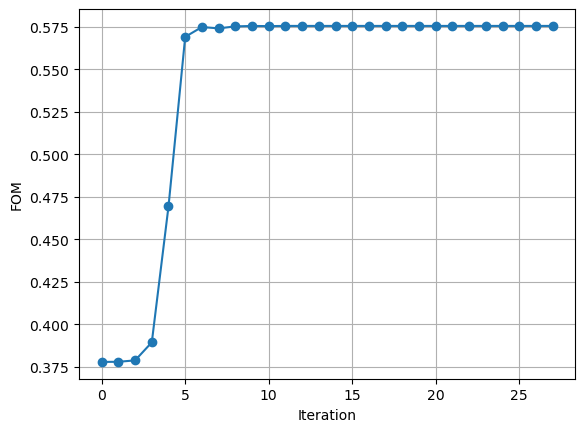

In [10]:
plt.figure()

plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()

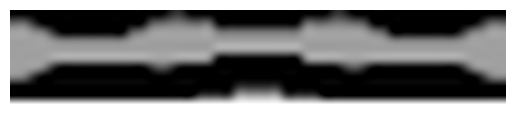

In [11]:
opt.update_design([mapping(x, eta_i, cur_beta/beta_scale)]) # cur_beta/beta_scale is the final beta in the optimization.
plt.figure()
ax = plt.gca()
opt.plot2D(
    False,
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    ax=ax,
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
circ = Circle((2, 2), minimum_length / 2)
ax.add_patch(circ)
ax.axis("off")
plt.show()

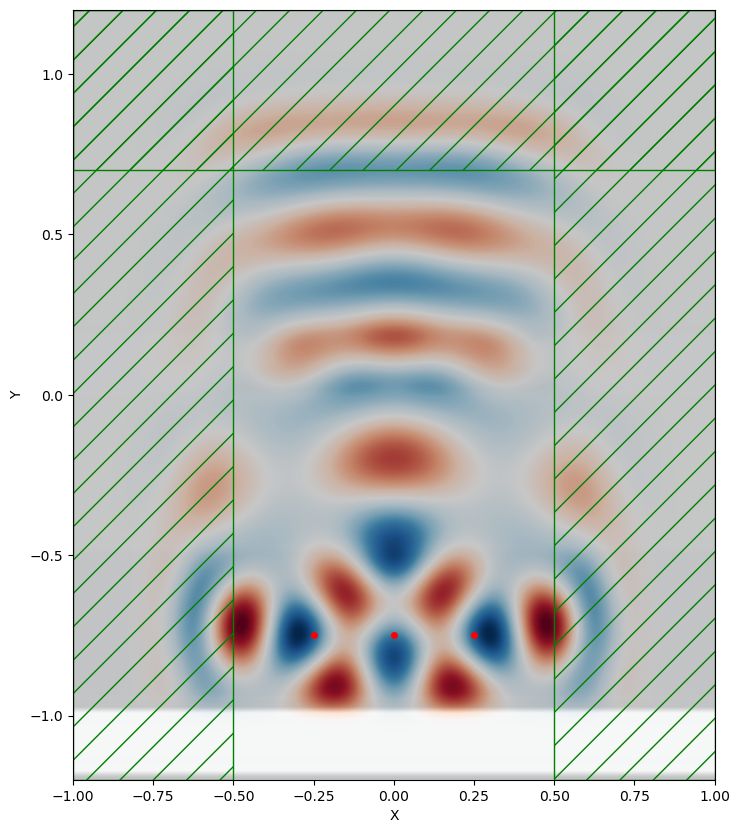

In [12]:
opt.sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,)
src = mp.ContinuousSource(frequency=fcen, fwidth=df, is_integrated=True)
source = []
src_num = 3

for i in range(src_num):  # x 방향 루프
        source.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG,
                    z = 0
                )
            )
        )

opt.sim.change_sources(source)

plt.figure(figsize=(16, 10))

opt.sim.run(until=300)
opt.sim.plot2D(fields=mp.Ez)
opt.sim.reset_meep()

In [13]:
opt.sim.reset_meep()

In [14]:
opt.sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,)

In [15]:
# surround source with a six-sided box of flux planes                                                             
srcbox_width = (design_region_width)*(math.trunc(src_num)/(src_num+1))
srcbox_top = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
srcbox_bot = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
srcbox_right = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
srcbox_left = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

# padding for flux box to fully capture waveguide mode                                                            
fluxbox_dpad = 0.05

glass_flux = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
wvgbox_right = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
wvgbox_left = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))



<Axes: xlabel='X', ylabel='Y'>

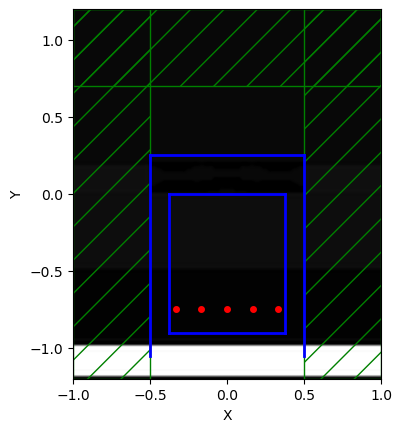

In [16]:
opt.sim.plot2D()

In [17]:
opt.sim.run(until=100.0)

In [18]:
flux_srcbox_top = np.asarray(mp.get_fluxes(srcbox_top))
flux_srcbox_bot = np.asarray(mp.get_fluxes(srcbox_bot))
flux_srcbox_right = np.asarray(mp.get_fluxes(srcbox_right))
flux_srcbox_left = np.asarray(mp.get_fluxes(srcbox_left))

flux_glass = np.asarray(mp.get_fluxes(glass_flux))
flux_wvgbox_right = np.asarray(mp.get_fluxes(wvgbox_right))
flux_wvgbox_left = np.asarray(mp.get_fluxes(wvgbox_left))

flux_freqs = mp.get_flux_freqs(glass_flux)



In [19]:
flux_total_srcbox = flux_srcbox_top - flux_srcbox_bot + flux_srcbox_right - flux_srcbox_left
flux_total_glass = flux_glass
flux_waveguide = flux_wvgbox_right - flux_wvgbox_left

In [20]:
print(flux_waveguide)

[4.61656963e-06 2.30275669e-05 1.38448610e-04 8.15966190e-04
 2.01997491e-03 3.43325067e-03 8.02167035e-03 3.36459888e-02
 1.20096202e-01 2.37046438e-01 2.81335889e-01 3.29621520e-01
 3.38824153e-01 3.27008108e-01 3.52703710e-01 1.72881324e-01
 6.58955159e-02 4.14000234e-02 2.90226322e-02 1.46098680e-02
 5.82739201e-03 2.04334456e-03 5.93187345e-04 1.50516608e-04
 3.46438250e-05]


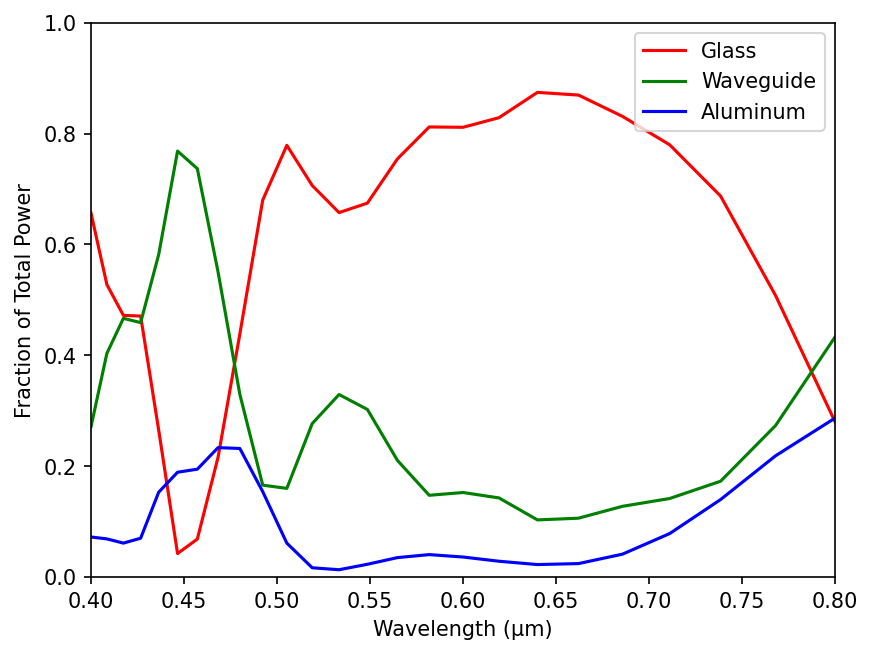

In [21]:
# totalflux 대비 효율

wl = []
gl = []
wg = []
al = []
for d in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[d]))
    gl = np.append(gl, flux_total_glass[d] / flux_total_srcbox[d])
    wg = np.append(wg, flux_waveguide[d] / flux_total_srcbox[d])
    al = 1 - gl - wg


if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, gl, "r", label="Glass")
    plt.plot(wl, wg, "g", label="Waveguide")
    plt.plot(wl, al, "b", label="Aluminum")

    
    plt.axis([0.40, 0.80, 0, 1])
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Fraction of Total Power")
    plt.legend(loc="upper right")
    plt.show()
    plt.cla()   # clear the current axes
    plt.clf()   # clear the current figure
    plt.close() # closes the current figure

In [22]:
geometryo = [
    mp.Block(material=GLS,      # 유리층
             size=mp.Vector3(mp.inf, tPML + tGLS),
             center=mp.Vector3(y=0.5*Sy - 0.5*(tPML + tGLS))),

    mp.Block(material=GLS,      # 디자인 영역
             size=mp.Vector3(mp.inf, design_region_height),
             center=design_region.center),
    
    mp.Block(material=ITO,      # ITO 층
             size=mp.Vector3(mp.inf, tITO),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - 0.5*tITO)),
    
    mp.Block(material=ORG,                       # 유기층
             size=mp.Vector3(mp.inf, tORG),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG)),
    
    mp.Block(material=ALU,                       # 알루미늄 층
             size=mp.Vector3(mp.inf, tALU),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - tORG - 0.5*tALU))
]

In [23]:
# opt.simo.reset_meep()

In [24]:
opt.simo = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometryo,
                    sources=sources,)

In [25]:
# surround source with a six-sided box of flux planes                                                             
srcbox_width = (design_region_width)*(math.trunc(src_num)/(src_num+1))
srcbox_top = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
srcbox_bot = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
srcbox_right = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
srcbox_left = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

# padding for flux box to fully capture waveguide mode                                                            
fluxbox_dpad = 0.05

glass_flux = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
wvgbox_right = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
wvgbox_left = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))


<Axes: xlabel='X', ylabel='Y'>

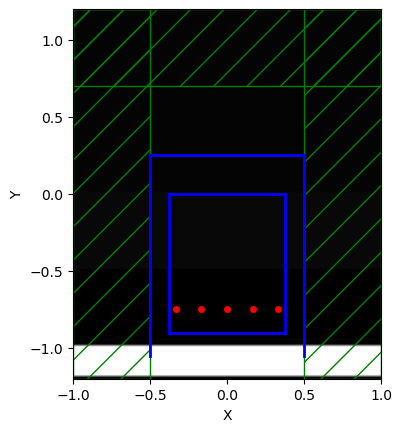

In [26]:
opt.simo.plot2D()

In [27]:
opt.simo.run(until=300.0)

In [28]:
flux_srcbox_top = np.asarray(mp.get_fluxes(srcbox_top))
flux_srcbox_bot = np.asarray(mp.get_fluxes(srcbox_bot))
flux_srcbox_right = np.asarray(mp.get_fluxes(srcbox_right))
flux_srcbox_left = np.asarray(mp.get_fluxes(srcbox_left))

flux_glass = np.asarray(mp.get_fluxes(glass_flux))
flux_wvgbox_right = np.asarray(mp.get_fluxes(wvgbox_right))
flux_wvgbox_left = np.asarray(mp.get_fluxes(wvgbox_left))

flux_freqs = mp.get_flux_freqs(glass_flux)


In [29]:
flux_total_srcbox = flux_srcbox_top - flux_srcbox_bot + flux_srcbox_right - flux_srcbox_left
flux_total_glass = flux_glass
flux_waveguide = flux_wvgbox_right - flux_wvgbox_left

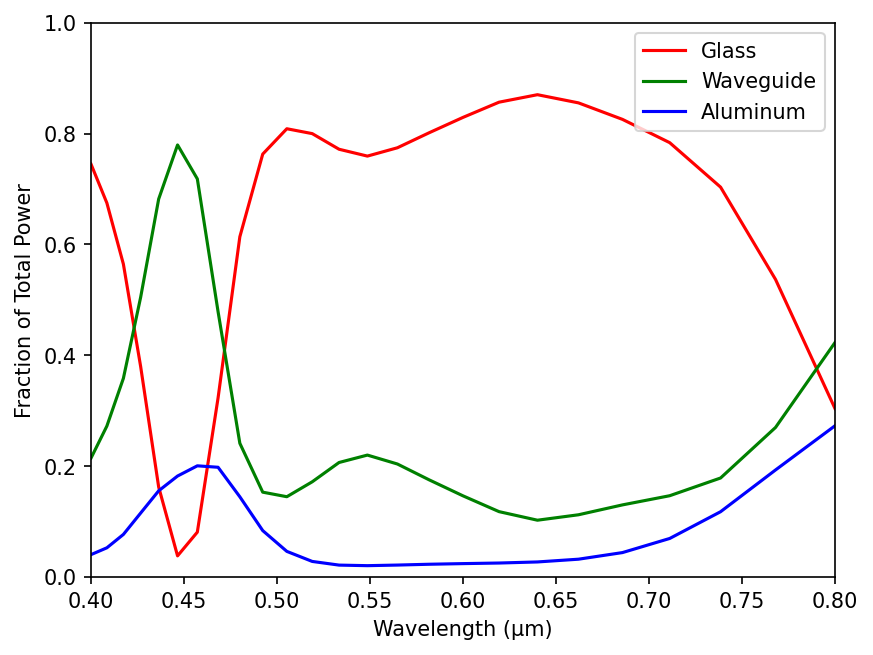

In [30]:
# totalflux 대비 효율

wl = []
gl = []
wg = []
al = []
for d in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[d]))
    gl = np.append(gl, flux_total_glass[d] / flux_total_srcbox[d])
    wg = np.append(wg, flux_waveguide[d] / flux_total_srcbox[d])
    al = 1 - gl - wg


if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, gl, "r", label="Glass")
    plt.plot(wl, wg, "g", label="Waveguide")
    plt.plot(wl, al, "b", label="Aluminum")

    
    plt.axis([0.40, 0.80, 0, 1])
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Fraction of Total Power")
    plt.legend(loc="upper right")
    plt.show()
    plt.cla()   # clear the current axes
    plt.clf()   # clear the current figure
    plt.close() # closes the current figure

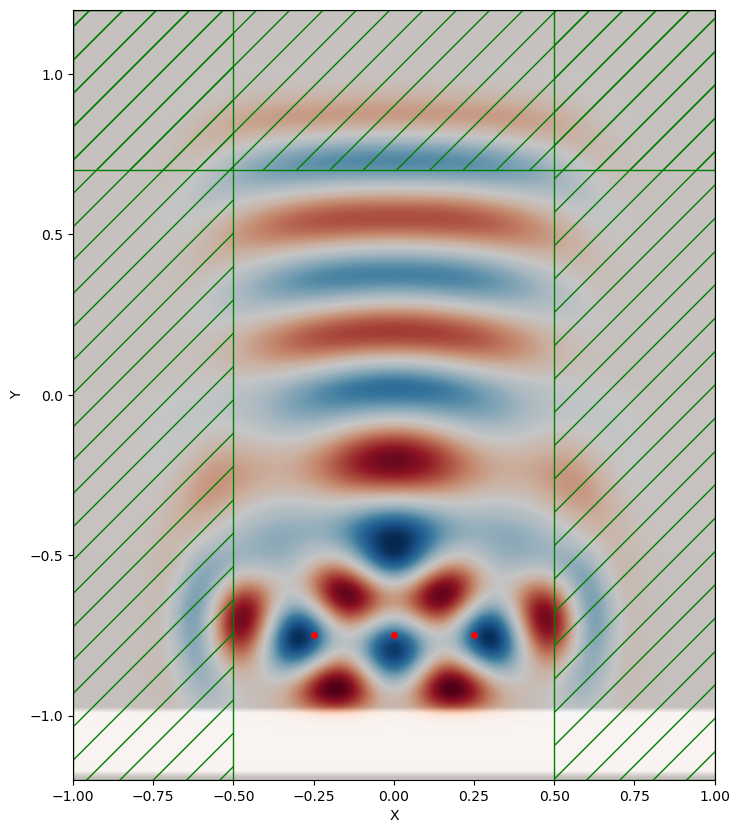

In [31]:
opt.simo.reset_meep()
opt.simo = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometryo,
                    sources=sources,)
src = mp.ContinuousSource(frequency=fcen, fwidth=df, is_integrated=True)
source = []
src_num = 3

for i in range(src_num):  # x 방향 루프
        source.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG,
                    z = 0
                )
            )
        )

opt.simo.change_sources(source)

plt.figure(figsize=(16, 10))

opt.simo.run(until=300)
opt.simo.plot2D(fields=mp.Ez)
opt.simo.reset_meep()